# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем необходимые библиотеки:

In [2]:
%pip install phik -q
%pip install lightgbm -q
%pip install catboost -q



You should consider upgrading via the '/Users/polina.piskovatskova/Documents/YP/projects/practicum_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/polina.piskovatskova/Documents/YP/projects/practicum_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/polina.piskovatskova/Documents/YP/projects/practicum_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import pandas as pd
pd.set_option('display.max_rows', None)

import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


RANDOM_STATE=42

Импортируем данные. Визуально оценим их.

In [4]:
file_path = '/datasets/autos.csv'
if os.path.exists(file_path):
    autos = pd.read_csv(file_path)
else:
    autos = pd.read_csv('/Users/polina.piskovatskova/Documents/YP/datasets/Car_store_gradient_boosting/autos.csv')

autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
autos = autos.reset_index(drop=False)
autos.rename(columns={'index' : 'id'}, inplace=True)
autos = autos.reset_index(drop=True)


In [6]:
autos.head()

,id,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 354369 non-null  int64 
 1   DateCrawled        354369 non-null  object
 2   Price              354369 non-null  int64 
 3   VehicleType        316879 non-null  object
 4   RegistrationYear   354369 non-null  int64 
 5   Gearbox            334536 non-null  object
 6   Power              354369 non-null  int64 
 7   Model              334664 non-null  object
 8   Kilometer          354369 non-null  int64 
 9   RegistrationMonth  354369 non-null  int64 
 10  FuelType           321474 non-null  object
 11  Brand              354369 non-null  object
 12  Repaired           283215 non-null  object
 13  DateCreated        354369 non-null  object
 14  NumberOfPictures   354369 non-null  int64 
 15  PostalCode         354369 non-null  int64 
 16  LastSeen           3

**Описание данных:**  

Признаки:  

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:

*Price* — цена (евро)

autos.info()

Обозначим категориальные и количественные признаки.
Исключим из входных признаков:
- дату скачивания анкеты из базы, так как не должно влиять на цену;
- месяц регистрации автомобиля, так как влияние оказывает год регистрации;
- почтовый индекс владельца анкеты - может влиять, если определять по индексам город проживания, но рыночная стоимость должна округлять стоимость в разных городах одной страны примерно до одинаковой;
- количество фотографий автомобиля тоже не должно влиять на цену;
- дата последней активности пользователя - не влияет на рыночную цену автомобиля.

In [8]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_features = ['RegistrationYear', 'Power', 'Kilometer']

In [9]:
print(f'Количество пропусков в autos:\n{autos.isna().sum()}')

Количество пропусков в autos:
id                       0
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


В столбцах VehicleType, Gearbox, Model, FuelType, Repaired, DateCreated есть пропуски. Далее обработаем их.

In [10]:
autos[autos['VehicleType'].isna()].head()

,id,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07


Проверим дубликаты:

In [11]:
autos[autos.duplicated()]

,id,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Проведем исследовательский анализ данных: проверим, есть ли выбросы, аномалии, некорректные значения.

In [12]:
# Используем функцию для исследовательского анализа количественных признаков
def describe_numeric(dataframe, param, bins=200, color='violet'):
    """ Функция для исследовательского анализа количественных признаков"""
    
    # Описательная статистика
    print(dataframe[param].describe())
    
    # Гистограмма
    plt.figure(figsize=(10, 5))
    plt.hist(dataframe[param], bins=bins, color='dodgerblue', edgecolor='black')
    plt.title(f'Гистограмма распределения параметра {param}')
    plt.xlabel(f'{param}')
    plt.ylabel('Частота')
    plt.show()
    
    # Ящик с усами
    plt.figure(figsize=(10, 5))
    dataframe[param].plot.box(title=f'Ящик с усами для {param}')
    plt.show()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


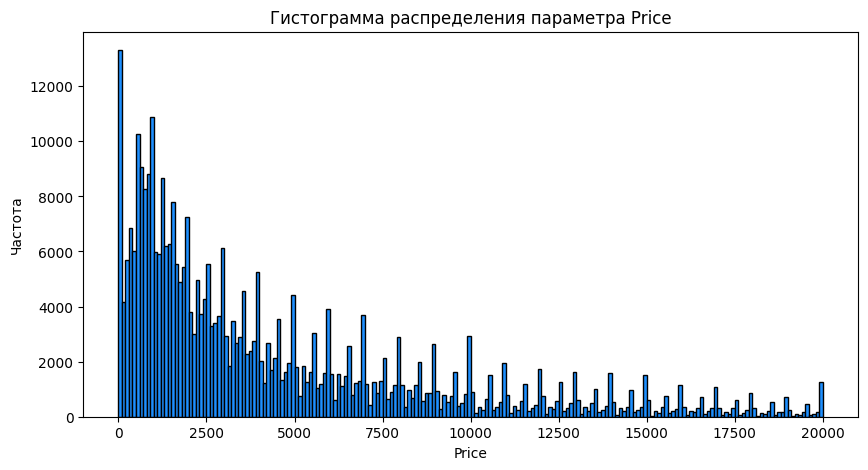

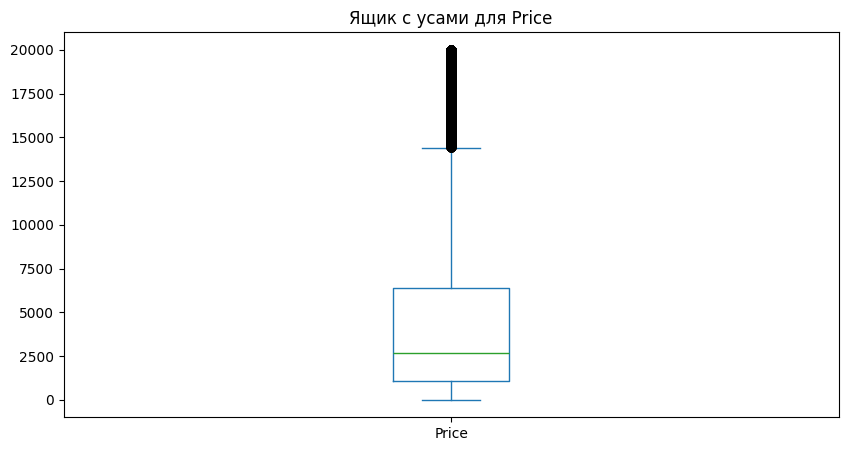

In [13]:
# Применяем функцию к целевому признаку - Price
describe_numeric(autos, 'Price')

Цена представлена в евро. Минимальная цена - 0, есть также много автомобилей, цена которых ниже возможной для подержанного автомобиля. Определим нижнюю границу 5% квантилем.

In [14]:
print(f"Примем за нижнюю границу стоимости подержанного автомобиля {autos['Price'].quantile(0.05)} евро")

Примем за нижнюю границу стоимости подержанного автомобиля 200.0 евро


In [15]:
autos = autos[autos['Price'] >= 200]

count    336907.000000
mean       4643.615119
std        4515.337846
min         200.000000
25%        1250.000000
50%        2950.000000
75%        6650.000000
max       20000.000000
Name: Price, dtype: float64


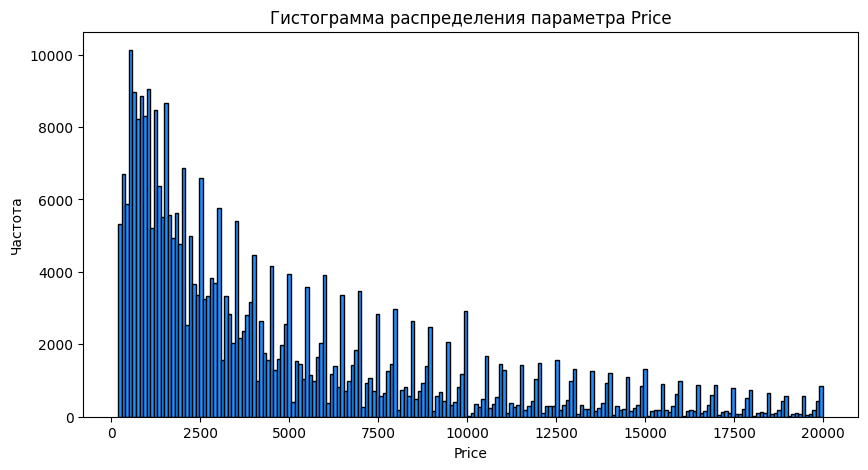

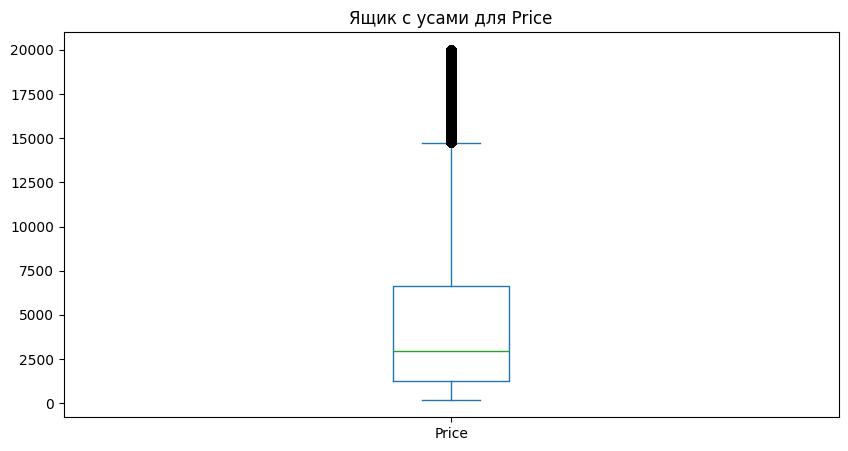

In [16]:
describe_numeric(autos, 'Price')

Максимальная стоимость автомобиля 20000 евро, медианная 3300. Выбросы на распределении цены можно объяснить "круглыми" значениями суммы. Распределение имеет вид распределения Пуассона.

count    336907.000000
mean       2003.979947
std          67.938601
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


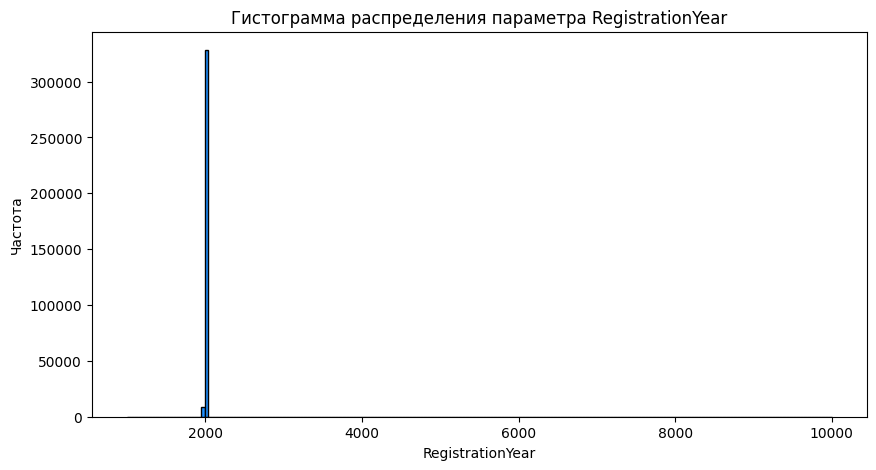

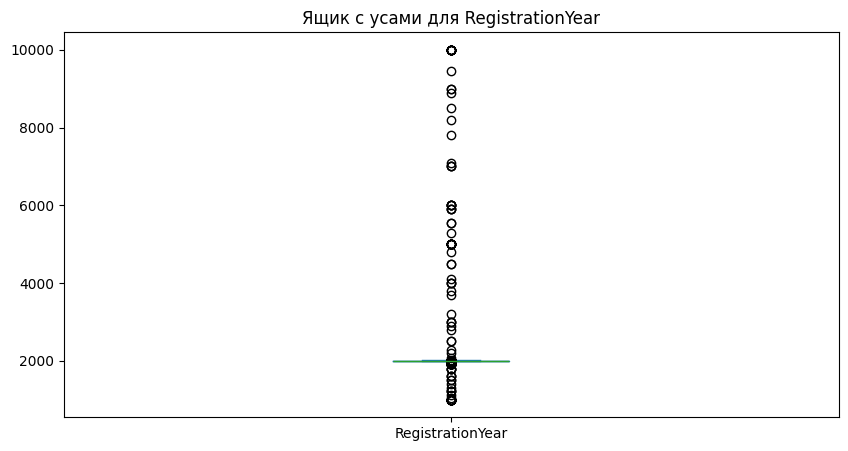

count    336907.000000
mean        112.112313
std         188.015264
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


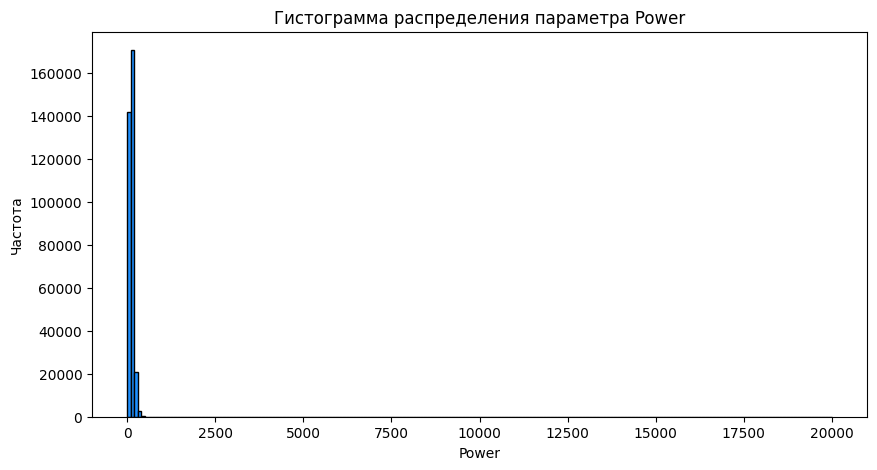

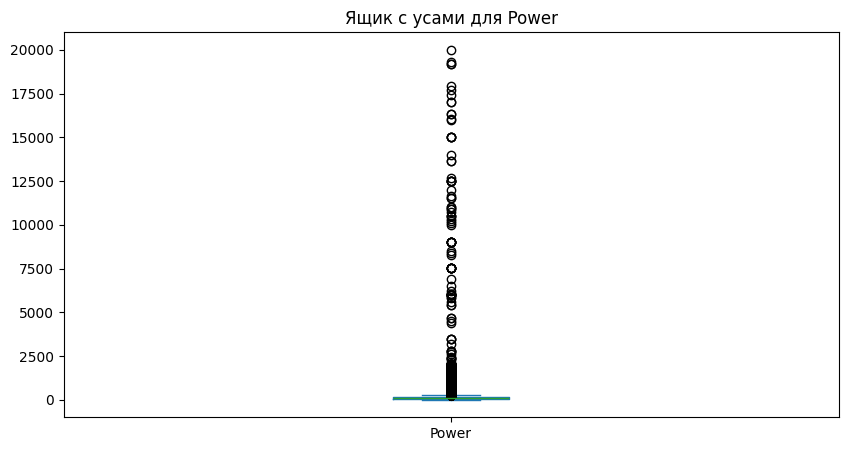

count    336907.000000
mean     128475.543696
std       37168.253591
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


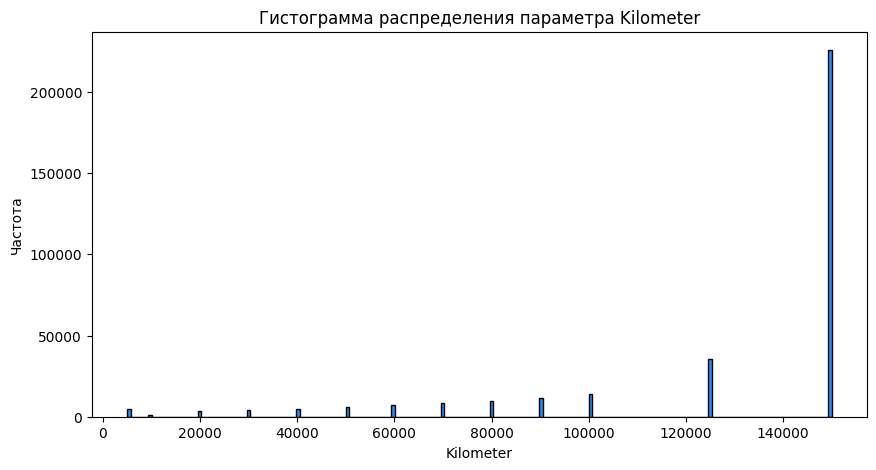

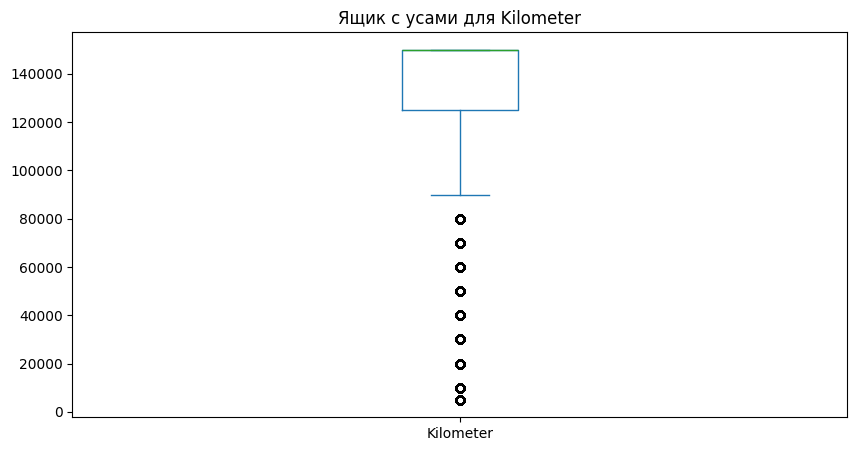

In [17]:
# Применяем функцию к каждому количественному признаку входных данных
for parameter in num_features:
    describe_numeric(autos, parameter)

In [18]:
# Проверим год выгрузки анкет
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])
autos['YearCrawled'] = autos['DateCrawled'].dt.year
autos['YearCrawled'].describe()

count    336907.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: YearCrawled, dtype: float64

Видимо, на сайте не может быть анкет автомобилей с годом регистрации позднее 2016. Изменим верхнюю границу.

Год регистрации автомобиля - важный признак, определяющий стоимость автомобиля. Чем старше автомобиль, тем меньше цена (обычно). В данных есть выбросы - максимум в 9999, минимум 1000. Удалим выбросы.

count    323252.000000
mean       2002.676698
std           6.832694
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


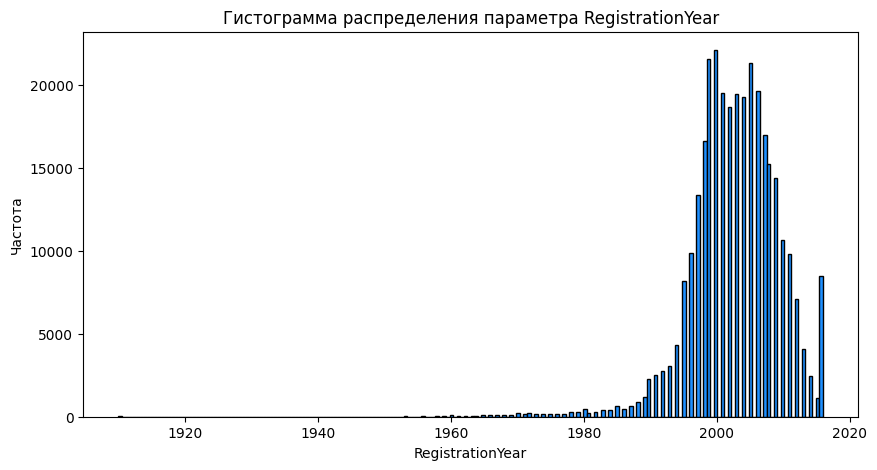

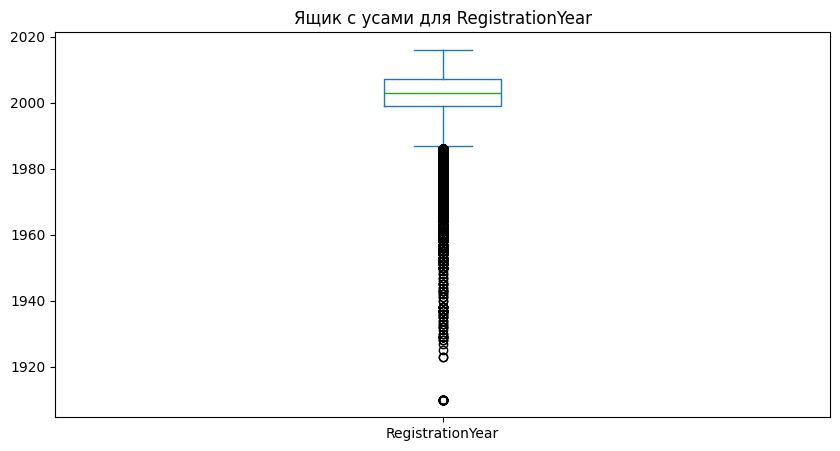

In [19]:
autos = autos[(autos['RegistrationYear'] <= 2016) & (autos['RegistrationYear'] > 1900)]
describe_numeric(autos, 'RegistrationYear')

In [20]:
autos[autos['RegistrationYear'] == 1910].head(10)

,id,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearCrawled
15,15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47,2016
10183,10183,2016-03-27 13:59:08,1250,NaN,1910,NaN,0,other,5000,0,NaN,audi,NaN,2016-03-27 00:00:00,0,18445,2016-04-07 10:45:31,2016
23750,23750,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,0,88662,2016-04-07 05:45:53,2016
35943,35943,2016-03-19 10:57:31,200,other,1910,NaN,0,caddy,150000,0,gasoline,volkswagen,NaN,2016-03-19 00:00:00,0,35096,2016-03-20 18:10:33,2016
48958,48958,2016-03-09 07:36:58,600,small,1910,manual,0,agila,5000,0,NaN,opel,yes,2016-03-09 00:00:00,0,61279,2016-04-06 05:46:18,2016
57063,57063,2016-03-30 07:36:23,1000,NaN,1910,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-30 00:00:00,0,63303,2016-04-06 16:45:19,2016
62803,62803,2016-03-07 22:58:46,3400,small,1910,manual,90,beetle,90000,4,NaN,volkswagen,no,2016-03-07 00:00:00,0,34308,2016-03-12 08:16:51,2016
74814,74814,2016-03-21 12:52:05,400,NaN,1910,NaN,60,golf,150000,0,petrol,volkswagen,NaN,2016-03-21 00:00:00,0,29462,2016-03-25 09:17:54,2016
78374,78374,2016-04-04 20:39:52,250,other,1910,NaN,0,NaN,5000,1,NaN,audi,NaN,2016-04-04 00:00:00,0,99947,2016-04-06 22:46:27,2016
82829,82829,2016-03-14 08:51:18,500,NaN,1910,NaN,0,corsa,150000,0,NaN,opel,NaN,2016-03-14 00:00:00,0,52393,2016-04-03 07:53:55,2016


Также заметно множество значений в регистрации автомобиля в 1910 году. Корректных (известных) параметров для них меньше, а также сложно предсказывать рыночную стоимость винтажных автомобилей наравне с обычными авто. Скорее всего, это же характерно и для автомобилей до 1960 года, поэтому оставим для обучения моделей только автомобили, зарегистрированные позже 1960 года.

In [21]:
print(f"Автомобили, зарегистрированные до 1980г., составляют {round(100 * len(autos[autos['RegistrationYear'] < 1980])/len(autos), 3)}% от всех данных, поэтому оставим только автомобили, зарегистрированные после 1980")

Автомобили, зарегистрированные до 1980г., составляют 0.927% от всех данных, поэтому оставим только автомобили, зарегистрированные после 1980


count    320256.000000
mean       2002.985796
std           5.989844
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


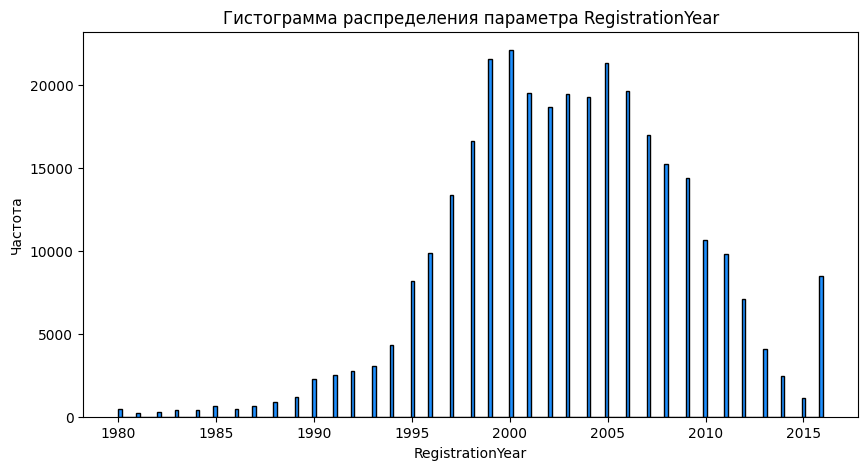

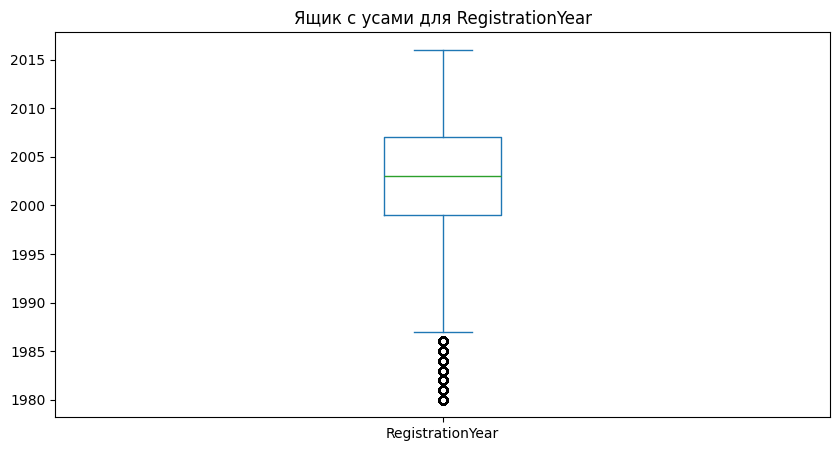

In [22]:
autos = autos[(autos['RegistrationYear'] >= 1980)]
describe_numeric(autos, 'RegistrationYear')

После преобразований распределение года регистрации автомобилей больше напоминает нормальное.  Медианное значение года регистрации автомобиля - 2003.  Самый последний год, присутствующий в базе, 2019.
Для параметра Power - мощность в лошадинных силах - присутствуют аномально высокие и низкие значения. Оставим только записи с мощностью от 50 до 500 л.с. включительно (удалось найти информацию о существовании индийской модели с мощностью двигателя 48 л.с и гоночных автомобилей с мощностью 500 л.с.).

count    285916.000000
mean        122.439877
std          52.705906
min          50.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         500.000000
Name: Power, dtype: float64


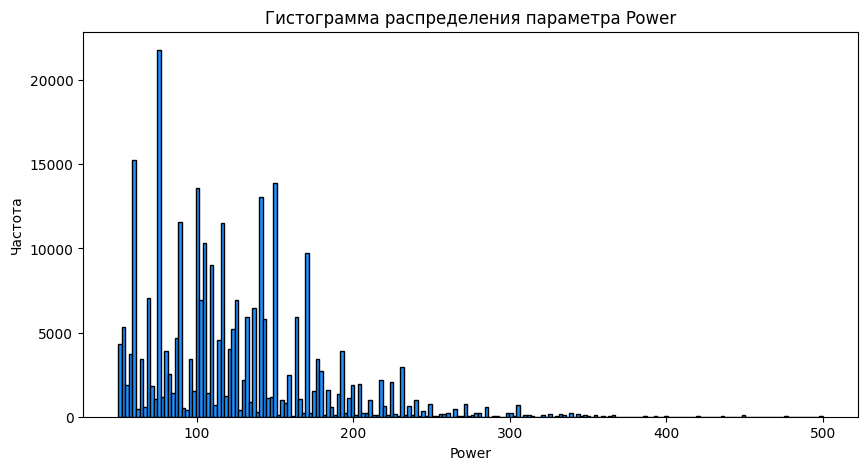

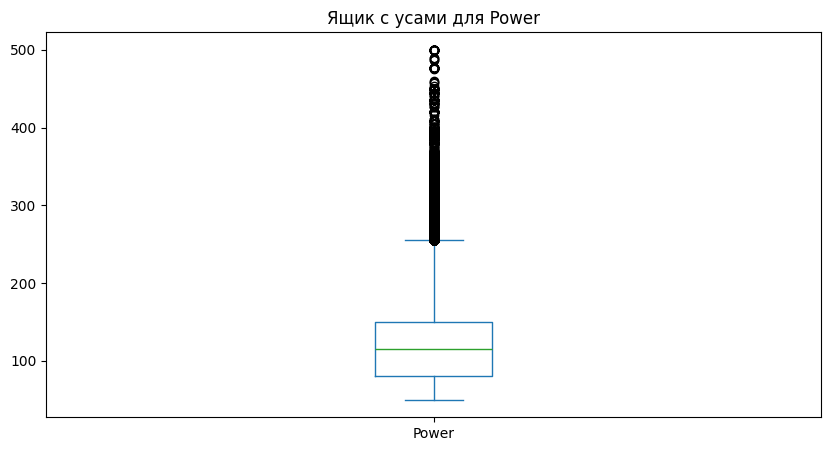

In [23]:
autos = autos[(autos['Power'] <= 500) & (autos['Power'] >= 50)]
describe_numeric(autos, 'Power')

Медианное значение мощности автомобилей 115 л.с. Распределение стремится к нормальному.

Параметр пробега Kilometer, видимо, ограничивается в приложении, так как значения выглядят дискретными, минимальный пробег составляет 5000 км, максимальный - 150000, большинство машин имеет максимальный пробег. 

Проверим количество пропусков после фильтрации данных.

In [24]:
print(f'Количество пропусков в autos:\n{autos.isna().sum()}')

Количество пропусков в autos:
id                       0
DateCrawled              0
Price                    0
VehicleType          10006
RegistrationYear         0
Gearbox               4700
Power                    0
Model                 9981
Kilometer                0
RegistrationMonth        0
FuelType             14192
Brand                    0
Repaired             40020
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
YearCrawled              0
dtype: int64


In [25]:
for col in autos[cat_features]:
    print(f'Уникальные значения столбца {col}:')
    print(autos[col].unique())
    print()

Уникальные значения столбца VehicleType:
['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' nan 'other']

Уникальные значения столбца Gearbox:
['manual' 'auto' nan]

Уникальные значения столбца Model:
[nan 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo'
 '1er' 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka' 'a1'
 'focus' 'a4' 'tt' 'astra' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz'
 'insignia' 'almera' 'megane' 'a3' 'r19' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'lupo' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan'
 'sp

Значения категориальных признаков адекватные, опечаток и дублирований нет. Однако для значений типа топлива можно заменить gasoline на petrol, cng на lpg.

In [26]:
autos['FuelType'].replace({'gasoline':'petrol', 'cng':'lpg'}, inplace=True)

/var/folders/mb/tdzwqv9137jby082pkr2y4c00000gn/T/ipykernel_3265/1787277161.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  autos['FuelType'].replace({'gasoline':'petrol', 'cng':'lpg'}, inplace=True)


In [27]:
# Проверим пропуски после обработки количественных признаков.
print(f'Количество пропусков в autos:\n{autos.isna().sum()}')

Количество пропусков в autos:
id                       0
DateCrawled              0
Price                    0
VehicleType          10006
RegistrationYear         0
Gearbox               4700
Power                    0
Model                 9981
Kilometer                0
RegistrationMonth        0
FuelType             14192
Brand                    0
Repaired             40020
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
YearCrawled              0
dtype: int64


Пропуски для значений типа кузова заполним самым популярным значением кузова и модели по бренду автомобиля.

In [28]:
# Находим самое частое значение типа кузова для каждого бренда
most_common_vehicle_type = (
    autos.groupby('Brand')['VehicleType']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Находим самое частое значение модели для каждого бренда
most_common_model = (
    autos.groupby('Brand')['Model']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

In [29]:
# Функция для заполнения пропусков на основе бренда
def fill_na(row, param, table):
    if pd.isna(row[param]):
        return table.get(row['Brand'], 'unknown')
    return row[param]

# Применяем функцию для заполнения пропусков
autos['VehicleType'] = autos.apply(fill_na, axis=1, param='VehicleType', table=most_common_vehicle_type)
autos['Model'] = autos.apply(fill_na, axis=1, param='Model', table=most_common_model)

print(autos['VehicleType'].isna().sum())
print(autos['Model'].isna().sum())

0
1259


Получилось заполнить не все пропуски моделей. Заменим пропущенные значения на 'unknown'.

In [30]:
autos['Model'] = autos['Model'].fillna('unknown')

Пропуски в типе коробки передач, типе топлива заполним по самому популярному среди одной модели автомобилей.

In [31]:
# Находим самое частое значение типа коробки передач для каждой модели
most_common_gearbox = (
    autos.groupby(['Brand', 'Model'])['Gearbox']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Находим самое частое значение типа топлива для каждой модели
most_common_fuel = (
    autos.groupby(['Brand', 'Model'])['FuelType']
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Преобразуем most_common_gearbox и most_common_fuel в словари с ключами (Brand, Model)
most_common_gearbox_dict = most_common_gearbox.to_dict()
most_common_fuel_dict = most_common_fuel.to_dict()

In [32]:
def fill_na_dict(row, param, table):
    key = (row['Brand'], row['Model'])  # Создаем ключ из Brand и Model
    if pd.isna(row[param]):
        return table.get(key, 'unknown')  # Ищем значение в таблице по ключу
    return row[param]
# Применяем функцию для заполнения пропусков
autos['Gearbox'] = autos.apply(
    fill_na_dict, axis=1, param='Gearbox', table=most_common_gearbox_dict
)
autos['FuelType'] = autos.apply(
    fill_na_dict, axis=1, param='FuelType', table=most_common_fuel_dict
)

# Проверяем результат
print(autos['Gearbox'].isna().sum())
print(autos['FuelType'].isna().sum())

0
0


Пропуски в столбце наличия ремонта заполним на утвердительное значение 'yes', так как это более вероятно и менее рискованно. Также изменим тип данных на бинарный (1/0).

In [33]:
autos['Repaired'] = autos['Repaired'].fillna('yes')
autos['Repaired'] = autos['Repaired'].apply(lambda x: 1 if x == 'yes' else 0)

In [34]:
autos['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

Так как для Gearbox есть два уникальных значения, заменим значения manual на 0, auto на 1.

In [35]:
autos['Gearbox'] = autos['Gearbox'].apply(lambda x: 1 if x == 'auto' else 0)

In [36]:
print(f'Количество пропусков в autos:\n{autos.isna().sum()}')

Количество пропусков в autos:
id                   0
DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
YearCrawled          0
dtype: int64


In [37]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285916 entries, 1 to 354368
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 285916 non-null  int64         
 1   DateCrawled        285916 non-null  datetime64[ns]
 2   Price              285916 non-null  int64         
 3   VehicleType        285916 non-null  object        
 4   RegistrationYear   285916 non-null  int64         
 5   Gearbox            285916 non-null  int64         
 6   Power              285916 non-null  int64         
 7   Model              285916 non-null  object        
 8   Kilometer          285916 non-null  int64         
 9   RegistrationMonth  285916 non-null  int64         
 10  FuelType           285916 non-null  object        
 11  Brand              285916 non-null  object        
 12  Repaired           285916 non-null  int64         
 13  DateCreated        285916 non-null  object       

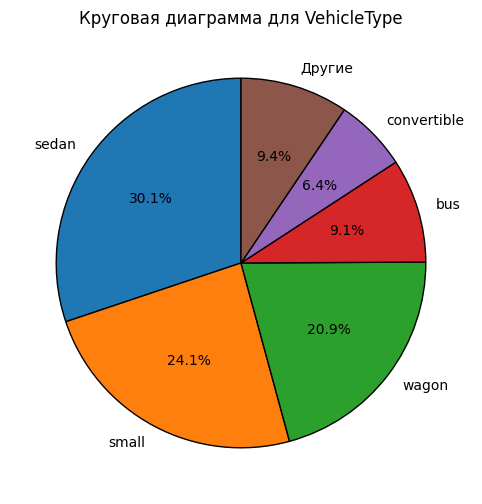

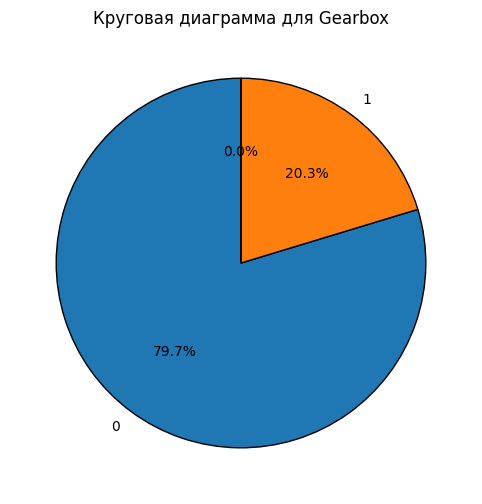

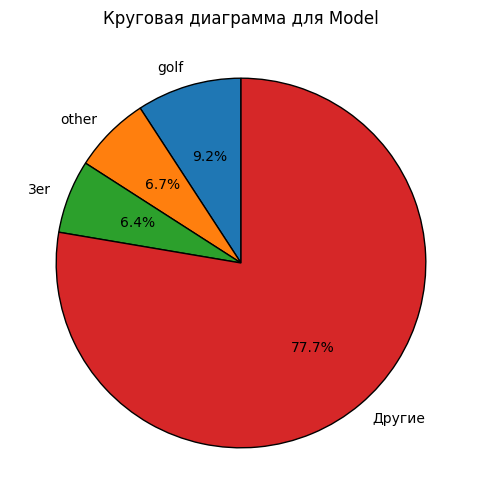

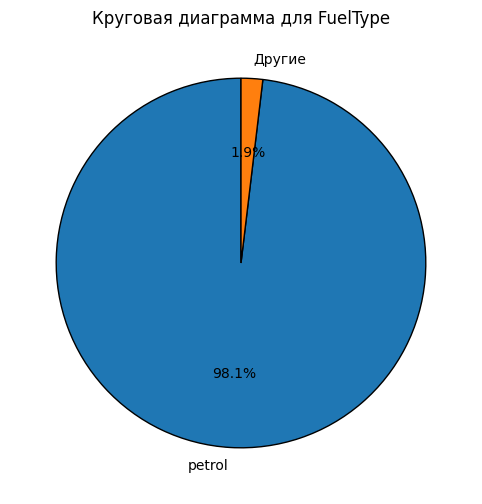

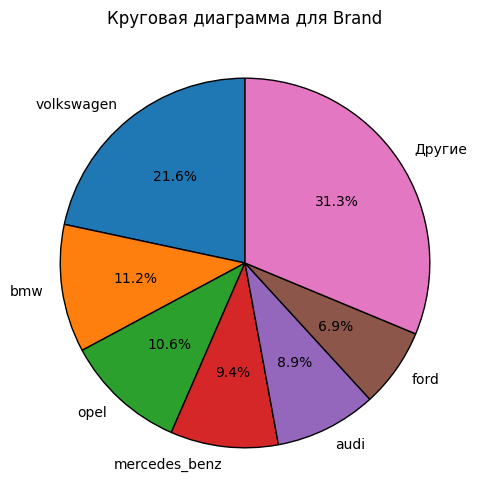

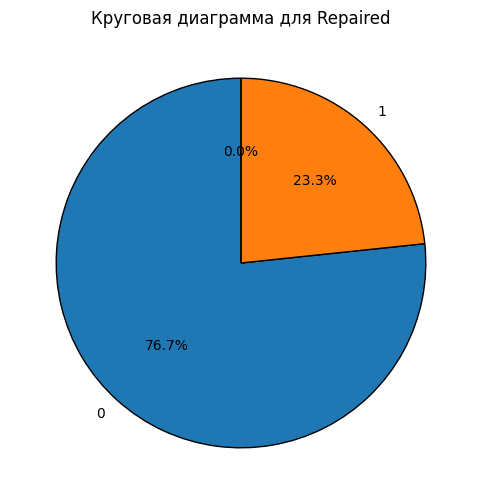

In [38]:
# Воспользуемся функцией для исследовательского анализа категориальных признаков.
def pie_plot(dataframe, param, threshold=0.05):
    # Рассчитываем долю каждой категории
    value_counts = dataframe[param].value_counts(normalize=True)
    
    # Сгруппируем категории с долей ниже порога
    grouped_values = value_counts[value_counts >= threshold]
    grouped_values['Другие'] = value_counts[value_counts < threshold].sum()

    # Построим круговую диаграмму
    plt.figure(figsize=(10, 6))
    grouped_values.plot.pie(
        title=f'Круговая диаграмма для {param}',
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'black'},
        labels=grouped_values.index
    )
    plt.ylabel('')
    plt.show()

# Применяем функцию к каждому категориальному признаку
for parameter in cat_features:
    pie_plot(autos, parameter, threshold=0.05)

- Самый популярный **тип кузова** - sedan, далее идет small. Тип кузова должен влиять на цену, по крайней мере, среди машин одной ценовой категории (или бренда).
- 79.8% автомобилей на продажу имеют механическую **коробку передач**. Механическая коробка передач обычно дешевле.
- В базе представлено очень много **моделей автомобилей**, самые популярные - golf, 3er. Модель влияет на цену.
- **Тип топлива** "бензин" является самым популярным, характерен для 98.1% автомобилей.
- Чаще всего встречаются автомобили **бренда** Volkswagen, реже - BMW, Opel. Бренд определяет ценовую категорию.
- **Ремонт** автомобиля сильно влияет на стоимость автомобиля. 75.9% автомобилей не были на ремонте.  

Проверим зависимость между признаками и правильно ли определены основные факторы, которые могут повлять на цену.

/Users/polina.piskovatskova/Documents/YP/projects/practicum_env/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable NumberOfPictures for analysis 1. Dropping this column
  warnings.warn(


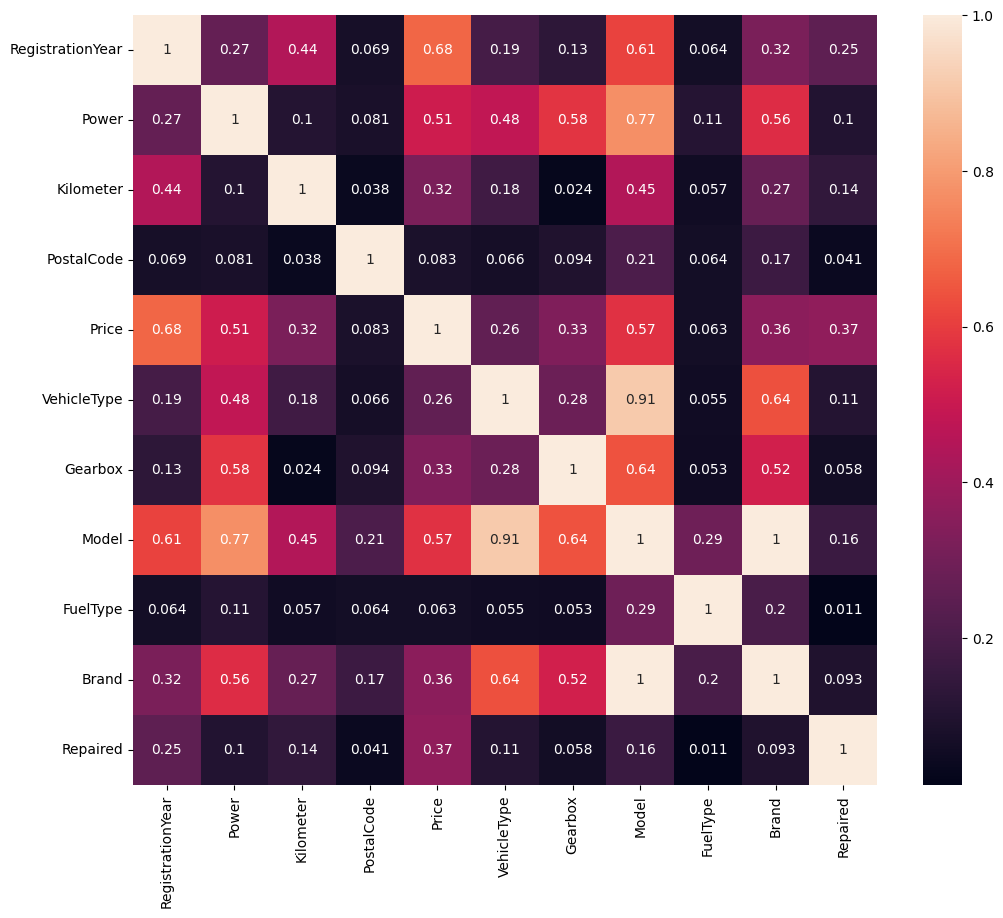

In [39]:
num_columns = num_features + ['PostalCode', 'NumberOfPictures', 'Price']
plt.figure(figsize=(12,10))
sns.heatmap(autos[num_columns + cat_features ].phik_matrix(interval_cols=num_columns), annot=True)
plt.show()

Признаки Brand, VehicleType и Model мультиколлинеарны (коэффициент корреляции Фи больше 0.9). Так цена больше зависит от модели автомобиля, удалим признак Model. VehicleType и  Brand не мультиколлинеарны.
Высокое влияние на цену автомобиля также имеют признаки RegistrationYear, Power, Kilometer, Brand, Repaired, а вот FuelType почти никак не коррелирует с ценой.

In [40]:
cat_features.remove('Model')

**Вывод:**. 

Загружены данные о технических характеристиках, комплектации и ценах других автомобилей.
Пропуски в  VehicleType, Gearbox, Model, FuelType обработаны модальным значением для модели или бренда автомобиля. Пропуски для Repaired обработаны с заменой на утверждение о наличии ремонта.
Удалены аномальные значения для Power, RegistrationYear, Price.

Для обучения моделей оставлены наиболее значимые признаки без мультиколлинеарности:  
 - FuelType,
 - VehicleType,
 - Brand
 - RegistrationYear,
 - Power,
 - Kilometer,
 - Repaired,
 - Gearbox.


## Обучение моделей

Подготовьте выборки для обучения моделей.
Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
Проанализируйте время обучения, время предсказания и качество моделей.
Опираясь на критерии заказчика, выберите лучшую модель, проверьте её качество на тестовой выборке.
Примечания:
Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.


Подготовим выборки для обучения моделей.

In [41]:
# features - входные признаки, target - целевой признак
features = autos[num_features + cat_features]
target = autos['Price']

In [42]:
# Разделим признаки на обучающую и тестовую в соотношении 75:25
X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

In [43]:
X_train.head()

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,FuelType,Brand,Repaired
191825,2001,170,150000,coupe,0,petrol,bmw,0
103282,1997,90,150000,convertible,0,petrol,volkswagen,0
7437,2002,75,150000,sedan,0,petrol,volkswagen,0
183543,1996,170,150000,coupe,0,petrol,bmw,0
2224,2008,143,150000,wagon,0,petrol,audi,1


In [44]:
y_train.head()

191825    3300
103282    1700
7437      1950
183543    3000
2224      8500
Name: Price, dtype: int64

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(214437, 8) (214437,)
(71479, 8) (71479,)


Определим признаки для кодирования и уникальные категории для OrdinalEncoder.

In [46]:
num_features

['RegistrationYear', 'Power', 'Kilometer']

In [47]:
cat_features

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

In [48]:
autos['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'electric'], dtype=object)

In [49]:
autos['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [50]:
autos['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'lancia', 'citroen', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'lada', 'trabant'], dtype=object)

In [51]:
autos['Repaired'].unique()

array([1, 0])

In [52]:
autos['Gearbox'].unique()

array([0, 1])

In [53]:
# Введем обозначения для типов исходных данных
# Категориальные признаки для кодирования OrdinalEncoder
ord_columns = [
    'VehicleType',
    'Brand',
    'FuelType'
]

# Количественные признаки 
numeric_columns = [
    'RegistrationYear',
    'Power',
    'Kilometer'
]

In [54]:
# Создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [
        (
        'simpleImputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',
        OrdinalEncoder(
            categories=[
                ['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'],
                ['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'lada', 'trabant'],
                ['petrol', 'lpg', 'other', 'hybrid', 'electric']
            ],
            handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ])

# Cоздаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('Gearbox', 'passthrough', ['Gearbox']),
     ('Repaired', 'passthrough', ['Repaired']),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), numeric_columns)
    ], 
    remainder='passthrough'
)

In [55]:
warnings.filterwarnings("ignore")
# Определяем параметры для RandomizedSearchCV
param_grid = {
    'models__max_features': range(1, 6),
    'models__min_samples_leaf': range(1, 5),
    'models__min_samples_split': range(1, 6),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

# Создаем пайплайн для модели
pipe_dt = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Используем RandomizedSearchCV для подбора лучших параметров
randomized_search_dt = RandomizedSearchCV(
    pipe_dt,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучение модели DecisionTreeRegressor
randomized_search_dt.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('Gearbox',
                                                                               'passthrough',
                                                                               ['Gearbox']),
                                                                              ('Repaired',
                                                                               'passthrough',
                                                                               ['Repaired']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[['coupe',
                                                                                                                            'suv',
                                                                                                                            'small',
                                                                                                                            '...
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'models__max_features': range(1, 6),
                                        'models__min_samples_leaf': range(1, 5),
                                        'models__min_samples_split': range(1, 6),
                                        'preprocessor__num': [StandardScaler(),
                                                              MinMaxScaler(),
                                                              'passthrough']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [56]:
cv_results_tree = pd.DataFrame(randomized_search_dt.cv_results_).sort_values(by='mean_test_score', ascending=False)
display(cv_results_tree[['mean_fit_time', 'mean_test_score', 'params', 'mean_score_time']].head())

,mean_fit_time,mean_test_score,params,mean_score_time
4,0.318364,-1818.589952,"{'preprocessor__num': 'passthrough', 'models__...",0.028188
1,0.372092,-1835.191929,"{'preprocessor__num': 'passthrough', 'models__...",0.044021
0,0.339728,-1837.009977,"{'preprocessor__num': 'passthrough', 'models__...",0.040631
9,0.238573,-1850.436803,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.024875
7,0.236601,-1927.481380,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.034281


In [57]:
print(f"Лучшая метрика модели DecisionTreeRegressor на тренировочных данных (RMSE): {-1 * round(cv_results_tree.iloc[0]['mean_test_score'], 2)}.")
print(f"Время обучения модели при таком результате занимает: {round(cv_results_tree.iloc[0]['mean_fit_time'], 2)} с.")
print(f"Время предсказаний модели при таком результате занимает: {round(cv_results_tree.iloc[0]['mean_score_time'], 2)} с.")

Лучшая метрика модели DecisionTreeRegressor на тренировочных данных (RMSE): 1818.59.
Время обучения модели при таком результате занимает: 0.32 с.
Время предсказаний модели при таком результате занимает: 0.03 с.


In [58]:
# Определяем параметры для RandomizedSearchCV
param_grid_lgb = {
    'models__learning_rate': [0.01, 0.1],
    'models__max_depth': [3, 5, 7],
    'preprocessor__num': [MinMaxScaler(), 'passthrough']
}

# Создаем пайплайн для модели LightGBM
pipe_lgb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', lgb.LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE))
])

# Используем RandomizedSearchCV для подбора лучших параметров
randomized_search_lgb = RandomizedSearchCV(
    pipe_lgb,
    param_grid_lgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучение модели LightGBM
randomized_search_lgb.fit(X_train, y_train)

cv_results_lgb = pd.DataFrame(randomized_search_lgb.cv_results_).sort_values(by='mean_test_score', ascending=False)
display(cv_results_lgb.head())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_depth,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,4.072183,0.089926,0.195012,0.081606,passthrough,7,0.1,"{'preprocessor__num': 'passthrough', 'models__...",-1726.516540,-1722.824951,-1707.772790,-1722.931215,-1737.625814,-1723.534262,9.557789,1
0,4.176356,0.238675,0.153066,0.056242,MinMaxScaler(),7,0.1,"{'preprocessor__num': MinMaxScaler(), 'models_...",-1726.516575,-1722.824951,-1707.772790,-1724.836559,-1737.682389,-1723.926653,9.580365,2
1,3.563202,0.275133,0.256986,0.080973,passthrough,5,0.1,"{'preprocessor__num': 'passthrough', 'models__...",-1767.771285,-1761.200997,-1744.318070,-1757.131016,-1767.442285,-1759.572731,8.607718,3
3,3.394834,0.363450,0.094977,0.018993,MinMaxScaler(),5,0.1,"{'preprocessor__num': MinMaxScaler(), 'models_...",-1767.771285,-1761.200997,-1744.318070,-1759.562011,-1767.269924,-1760.024457,8.494691,4
9,1.491724,0.222703,0.088615,0.087838,passthrough,3,0.1,"{'preprocessor__num': 'passthrough', 'models__...",-1936.797830,-1921.095266,-1903.391535,-1921.125615,-1920.031342,-1920.488318,10.576233,5


In [59]:
print(f"Лучшая метрика модели LGBMRegressor на тренировочных данных (RMSE): {-1 * round(cv_results_lgb.iloc[0]['mean_test_score'], 2)}.")
print(f"Время обучения модели при таком результате занимает: {round(cv_results_lgb.iloc[0]['mean_fit_time'], 2)} с.")
print(f"Время предсказаний модели при таком результате занимает: {round(cv_results_tree.iloc[0]['mean_score_time'], 2)} с.")

Лучшая метрика модели LGBMRegressor на тренировочных данных (RMSE): 1723.53.
Время обучения модели при таком результате занимает: 4.07 с.
Время предсказаний модели при таком результате занимает: 0.03 с.


Обучим также модель Catboost, передавая ей категориальные признаки напрямую без обработки.
Для большей скорости, не будем использовать подбор гиперпараметров. RandomizedSearch используем для вычисления метрик.

In [60]:
cat_features_for_catboost = ['VehicleType', 'FuelType', 'Brand']
# задаем параметры для модели CatBoost
param_grid_catboost = {
    'learning_rate': [0.3],
    'depth': [6]
}
# Создаем модель CatBoost
catboost_model = CatBoostRegressor(
    random_seed=RANDOM_STATE,
    verbose=0,
    iterations=5,
    loss_function='RMSE'
)

# RandomizedSearchCV
randomized_search_catboost = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid_catboost,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_iter=50,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Обучение модели с указанием cat_features
randomized_search_catboost.fit(X_train, y_train, cat_features=cat_features_for_catboost)

# Вывод результатов
cv_results_catboost = pd.DataFrame(randomized_search_catboost.cv_results_).sort_values(by='mean_test_score', ascending=False)
display(cv_results_catboost.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.262749,0.007808,0.008295,0.001852,0.3,6,"{'learning_rate': 0.3, 'depth': 6}",-2359.467855,-2384.991903,-2364.038633,-2377.097716,-2386.853056,-2374.489833,10.998466,1


In [61]:
print(f"Лучшая метрика модели Catboost на тренировочных данных (RMSE): {-1 * round(cv_results_catboost.iloc[0]['mean_test_score'], 2)}.")
print(f"Время обучения модели при таком результате занимает: {round(cv_results_catboost.iloc[0]['mean_fit_time'], 2)} с.")
print(f"Время предсказаний модели при таком результате занимает: {round(cv_results_catboost.iloc[0]['mean_score_time'], 2)} с.")

Лучшая метрика модели Catboost на тренировочных данных (RMSE): 2374.49.
Время обучения модели при таком результате занимает: 0.26 с.
Время предсказаний модели при таком результате занимает: 0.01 с.


## Анализ моделей

In [62]:
# Сводная таблица по всем моделям
summary_df = pd.DataFrame([
    {'Model': 'DecisionTreeRegressor', 
     'Best RMSE': -1 * round(cv_results_tree.iloc[0]['mean_test_score'], 2),  # Закрыта скобка
     'Fit Time (sec)': round(cv_results_tree.iloc[0]['mean_fit_time'], 2),
     'Prediction Time (sec)': round(cv_results_tree.iloc[0]['mean_score_time'], 2)},
    
    {'Model': 'LightGBM', 
     'Best RMSE': -1 * round(cv_results_lgb.iloc[0]['mean_test_score'], 2),
     'Fit Time (sec)': round(cv_results_lgb.iloc[0]['mean_fit_time'], 2),
     'Prediction Time (sec)': round(cv_results_lgb.iloc[0]['mean_score_time'], 2)},
    
    {'Model': 'CatBoost', 
     'Best RMSE': -1 * round(cv_results_catboost.iloc[0]['mean_test_score'], 2),
     'Fit Time (sec)': round(cv_results_catboost.iloc[0]['mean_fit_time'], 2),
     'Prediction Time (sec)': round(cv_results_catboost.iloc[0]['mean_score_time'], 2)}
])

display(summary_df)

,Model,Best RMSE,Fit Time (sec),Prediction Time (sec)
0,DecisionTreeRegressor,1818.59,0.32,0.03
1,LightGBM,1723.53,4.07,0.20
2,CatBoost,2374.49,0.26,0.01


Модель DecisionTreeRegressor показывает хорошие результаты как по метрике RMSE, так и по времени обучения и предсказания (лучшее время).
LGBMRegressor() показывает результат метрики немного лучше, что говорит о более точных прогнозах, но при этом в разы проигрывает по времени обучения.
Модель Catboost без подбора гиперпараметров показывает качество предсказаний ниже, чем другие модели, но при этом не требует дополнительной обработки категориальных признаков. Скорость обучения в 2 раза ниже, чем у модели дереьвев.
Модели DecissionTree Catboost имеют сопоставимое время предсказаний. Модель LGBM значительно медленнее предсказывает значения.

Таким образом, для предсказания цены автомобилей рекомендуется использовать модель DecisionTreeRegressor, так как ее скорость обучения значительно опережает модели бустинга при сопоставимом качестве предсказания. Время предсказания также выше, чем для модели LGBM, но ниже, чем для Catboost в базовом варианте.

Поэтому тестировать будем модель DecisionTreeRegressor.

In [63]:
%%time
# Анализируем время предсказания и вычисляем RMSE для модели DecisionTreeRegressor
predictions_dt = randomized_search_dt.best_estimator_.predict(X_test)

CPU times: user 32.3 ms, sys: 3.25 ms, total: 35.6 ms
Wall time: 34.9 ms


In [64]:
# Вычисляем RMSE для тестовой выборки
rmse_dt = np.sqrt(mean_squared_error(y_test, predictions_dt))
print(f"RMSE на тестовых данных: {round(rmse_dt, 2)}")

RMSE на тестовых данных: 1771.83


RMSE на тестовых данных ниже, чем на тренировочных, что может говорить об отсутствии переобучения.

Посмотрим на важность факторов для обучения модели Decission Tree Regressor.

In [65]:
# Используем permutation importance для оценки важности признаков
permutation = permutation_importance(randomized_search_dt.best_estimator_, X_test, y_test, scoring='neg_root_mean_squared_error')

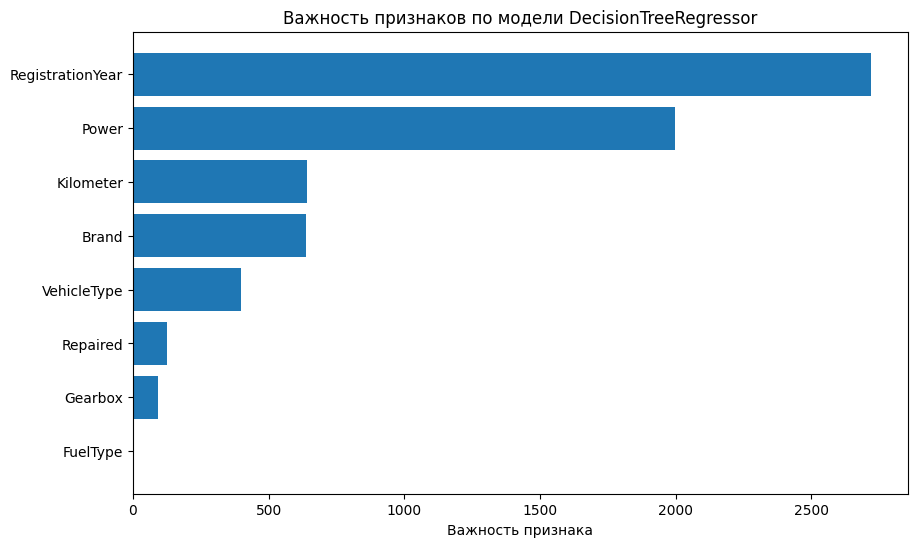

In [66]:
feature_names = X_train.columns
# Создаем DataFrame для важности признаков
feature_importance = pd.DataFrame({
    'Признак': feature_names[:len(permutation.importances_mean)], 
    'Значимость': permutation.importances_mean
})

# Сортируем признаки по значимости
sorted_importance = feature_importance.sort_values(by='Значимость', ascending=True)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_importance['Признак'], sorted_importance['Значимость'])
plt.xlabel('Важность признака')
plt.title('Важность признаков по модели DecisionTreeRegressor')
plt.show()

Наиболее значимым признаком является год регистрации автомобиля. Наименее важным - тип топлива, что было заметно из матрицы корреляции Фи.

In [67]:
permutation_lgb = permutation_importance(randomized_search_lgb.best_estimator_, X_test, y_test, scoring='neg_root_mean_squared_error')

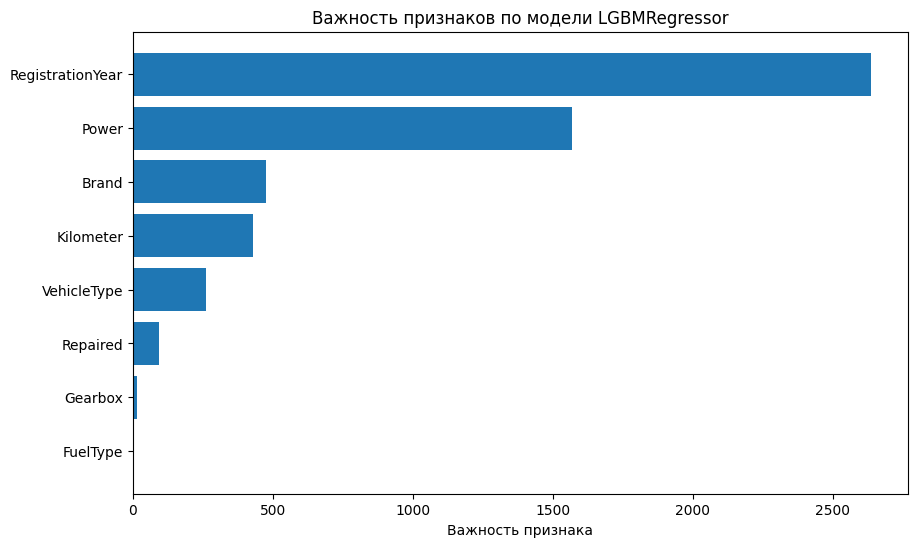

In [68]:
# Создаем DataFrame для важности признаков
feature_importance_lgb = pd.DataFrame({
    'Признак': feature_names[:len(permutation_lgb.importances_mean)], 
    'Значимость': permutation_lgb.importances_mean
})

# Сортируем признаки по значимости
sorted_importance_lgb = feature_importance_lgb.sort_values(by='Значимость', ascending=True)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(sorted_importance_lgb['Признак'], sorted_importance_lgb['Значимость'])
plt.xlabel('Важность признака')
plt.title('Важность признаков по модели LGBMRegressor')
plt.show()

Для модели бустинга значимость имеют те же признаки, что и для модели DecissionTree.

## Чек-лист проверки

### Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

### Вывод

В результате выполнения проекта:  

Загружены данные о технических характеристиках, комплектации и ценах других автомобилей.
Пропуски в  VehicleType, Gearbox, Model, FuelType обработаны модальным значением для модели или бренда автомобиля. Пропуски для Repaired обработаны с заменой на утверждение о наличии ремонта.
Удалены аномальные значения для Power, RegistrationYear, Price.

Для обучения моделей оставлены наиболее значимые признаки без мультиколлинеарности:  
 - FuelType,
 - VehicleType,
 - Brand
 - RegistrationYear,
 - Power,
 - Kilometer.

Обучены три модели - LGBMRegressor, DecisionTreeRegressor, Catboost.

Модель DecisionTreeRegressor показывает хорошие результаты как по метрике RMSE, так и по времени обучения и предсказания (лучшее время).
LGBMRegressor() показывает результат метрики немного лучше, что говорит о более точных прогнозах, но при этом в разы проигрывает по времени обучения.
Модель Catboost без подбора гиперпараметров показывает качество предсказаний ниже, чем другие модели, но при этом не требует дополнительной обработки категориальных признаков. Скорость обучения в 2 раза ниже, чем у модели дереьвев.
Модели DecissionTree Catboost имеют сопоставимое время предсказаний. Модель LGBM значительно медленнее предсказывает значения.

Таким образом, для предсказания цены автомобилей рекомендуется использовать модель DecisionTreeRegressor, так как ее скорость обучения значительно опережает модели бустинга при сопоставимом качестве предсказания. Время предсказания также выше, чем для модели LGBM, но ниже, чем для Catboost в базовом варианте.

Сводная таблица по метрикам моделей:

In [69]:
display(summary_df)

,Model,Best RMSE,Fit Time (sec),Prediction Time (sec)
0,DecisionTreeRegressor,1818.59,0.32,0.03
1,LightGBM,1723.53,4.07,0.20
2,CatBoost,2374.49,0.26,0.01


In [70]:
print(f"RMSE модели DecissionTreeRegressor на тестовых данных: {round(rmse_dt, 2)}")

RMSE модели DecissionTreeRegressor на тестовых данных: 1771.83
